###### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde
from numpy.core.multiarray import empty
from tabulate import tabulate
import plotly.express as px
import glob
# Adjust pandas settings to display columns
pd.set_option('display.max_rows', 100)

###### Importing CSV file

In [2]:
csv_files =  "./output_adaptive_detector/grid_search_results_adaptive_detector.csv"
df = pd.read_csv(csv_files)

In [3]:
df.shape

(10, 18)

In [4]:
# Remove './' and '.mp4' from the 'Video' column
df['Video'] = df['Video'].str.replace(r'^\./|\.mp4$', '', regex=True)

# Group by the 'Video' column and get the maximum F1 score for each video
highest_f1_scores = df.groupby('Video')['F1 Score'].max().reset_index()

# Rename the columns for clarity
highest_f1_scores.columns = ['Video', 'Highest F1 Score']

# Merge with the original DataFrame to filter rows that match the highest F1 score
merged_df = pd.merge(df, highest_f1_scores, on=['Video'])

# Now filter for rows where F1 Score is equal to the Highest F1 Score
count_of_highest_f1_scores = merged_df[merged_df['F1 Score'] == merged_df['Highest F1 Score']]

# Count how many times the highest F1 score appears for each video
highest_f1_counts = count_of_highest_f1_scores.groupby('Video').size().reset_index(name='Count of Highest F1 Score')

# Merge the highest F1 scores and their counts
final_result = pd.merge(highest_f1_scores, highest_f1_counts, on='Video', how='left')

# Display the final result without index
print(final_result.to_string(index=False))


Video  Highest F1 Score  Count of Highest F1 Score
    A          0.896552                          1
    B          0.896552                          1
    C          0.625000                          1
    D          0.827586                          1
    E          0.780488                          1
    F          0.810811                          1
    G          0.642857                          1
    H          0.711111                          1
    I          0.909091                          1
    J          0.914286                          1


In [5]:
count_of_highest_f1_scores.shape

(10, 19)

In [6]:
df.columns

Index(['Video', 'Adaptive Threshold', 'Window Width', 'Min Content Val',
       'Luma Only', 'Min Scene Len', 'Num Scenes Generated',
       'Ground Truth Frame Values', 'Detected Frame Values', 'True Positives',
       'False Positives', 'False Negatives', 'Precision', 'Recall', 'F1 Score',
       'FP Frames', 'FN Frames', 'Processing Time (s)'],
      dtype='object')

In [7]:
# Find the rows with the highest F1 Score for each Video
max_f1_rows = df.loc[df.groupby('Video')['F1 Score'].idxmax()]

# Select the relevant columns including parameters and highest F1 Score
selected_columns = ['Video', 'Adaptive Threshold', 'Window Width', 'Min Content Val', 
                    'Luma Only', 'Min Scene Len', 'F1 Score']
result_df = max_f1_rows[selected_columns]

# Display the result without index
print(result_df.to_string(index=False))

Video  Adaptive Threshold  Window Width  Min Content Val  Luma Only  Min Scene Len  F1 Score
    A                 1.5             6             14.0       True             15  0.896552
    B                 1.5             6             14.0       True             15  0.896552
    C                 1.5             6             14.0       True             15  0.625000
    D                 1.5             6             14.0       True             15  0.827586
    E                 1.5             6             14.0       True             15  0.780488
    F                 1.5             6             14.0       True             15  0.810811
    G                 1.5             6             14.0       True             15  0.642857
    H                 1.5             6             14.0       True             15  0.711111
    I                 1.5             6             14.0       True             15  0.909091
    J                 1.5             6             14.0       True   

In [8]:
# Find the rows with the highest F1 Score for each Video
max_f1_rows = df.loc[df.groupby('Video')['F1 Score'].idxmax()]

# Count the frequency of the highest F1 Score for each Video
f1_frequency = df.groupby('Video')['F1 Score'].apply(lambda x: (x == x.max()).sum())

# Add the frequency as a new column to max_f1_rows
max_f1_rows['Frequency of Highest F1'] = max_f1_rows['Video'].map(f1_frequency)

# Select the relevant columns including parameters, highest F1 Score, and frequency
selected_columns = ['Video', 'Adaptive Threshold', 'Window Width', 'Min Content Val', 
                    'Luma Only', 'Min Scene Len', 'F1 Score', 'Frequency of Highest F1']
result_df = max_f1_rows[selected_columns]

# Display the result without index
print(result_df.to_string(index=False))


Video  Adaptive Threshold  Window Width  Min Content Val  Luma Only  Min Scene Len  F1 Score  Frequency of Highest F1
    A                 1.5             6             14.0       True             15  0.896552                        1
    B                 1.5             6             14.0       True             15  0.896552                        1
    C                 1.5             6             14.0       True             15  0.625000                        1
    D                 1.5             6             14.0       True             15  0.827586                        1
    E                 1.5             6             14.0       True             15  0.780488                        1
    F                 1.5             6             14.0       True             15  0.810811                        1
    G                 1.5             6             14.0       True             15  0.642857                        1
    H                 1.5             6             14.0

In [9]:
# Print only the 'Frequency of Highest F1' column without the index
print(result_df['Frequency of Highest F1'].to_string(index=False))


1
1
1
1
1
1
1
1
1
1


In [10]:
# Rename columns in the DataFrame
df = df.rename(columns={
    'Video':'video',
    'Adaptive Threshold': 'adaptive_threshold',
    'Window Width': 'window_width',
    'Min Content Val': 'min_content_val',
    'Luma Only': 'luma_only',
    'Min Scene Len': 'min_scene_len',
    'F1 Score': 'f1',
    'Precision': 'precision',
    'Recall': 'recall'
})
#df['video'] = df['video'].str.replace('.mp4', '', regex=False)

In [11]:
# Specify the parameter names
parameter_names = ['adaptive_threshold', 'window_width', 'min_content_val', 'luma_only', 'min_scene_len']

# Create a dictionary to hold unique values
unique_values = {}

# Extract unique values for each parameter and sort them
for param in parameter_names:
    unique_values[param] = sorted(df[param].unique())

# Print the sorted unique values for each parameter
for param, values in unique_values.items():
    print(f"{param}: {values}")

adaptive_threshold: [1.5]
window_width: [6]
min_content_val: [14.0]
luma_only: [True]
min_scene_len: [15]


In [12]:
# Clean the 'video' column: Remove './' and '.mp4'
if 'video' in df.columns:
    df['video'] = df['video'].str.replace('./', '').str.replace('.mp4', '')

C:\Users\Yasin\anaconda3\envs\TransnetPySceneDetect\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   video                      10 non-null     object 
 1   adaptive_threshold         10 non-null     float64
 2   window_width               10 non-null     int64  
 3   min_content_val            10 non-null     float64
 4   luma_only                  10 non-null     bool   
 5   min_scene_len              10 non-null     int64  
 6   Num Scenes Generated       10 non-null     int64  
 7   Ground Truth Frame Values  10 non-null     object 
 8   Detected Frame Values      10 non-null     object 
 9   True Positives             10 non-null     int64  
 10  False Positives            10 non-null     int64  
 11  False Negatives            10 non-null     int64  
 12  precision                  10 non-null     float64
 13  recall                     10 non-null     float64
 1

In [14]:
print(df.columns)

Index(['video', 'adaptive_threshold', 'window_width', 'min_content_val',
       'luma_only', 'min_scene_len', 'Num Scenes Generated',
       'Ground Truth Frame Values', 'Detected Frame Values', 'True Positives',
       'False Positives', 'False Negatives', 'precision', 'recall', 'f1',
       'FP Frames', 'FN Frames', 'Processing Time (s)'],
      dtype='object')


In [15]:
# Find the highest and lowest values for F1 score
highest_f1 = df['f1'].max()
lowest_f1 = df['f1'].min()

# Find the highest and lowest values for False Positives
highest_fp = df['False Positives'].max()
lowest_fp = df['False Positives'].min()

# Find the highest and lowest values for False Negatives
highest_fn = df['False Negatives'].max()
lowest_fn = df['False Negatives'].min()

# Output the results
print(f"Highest F1 score: {highest_f1}")
print(f"Lowest F1 score: {lowest_f1}")
print(f"Highest False Positives: {highest_fp}")
print(f"Lowest False Positives: {lowest_fp}")
print(f"Highest False Negatives: {highest_fn}")
print(f"Lowest False Negatives: {lowest_fn}")


Highest F1 score: 0.9142857142857144
Lowest F1 score: 0.625
Highest False Positives: 11
Lowest False Positives: 0
Highest False Negatives: 5
Lowest False Negatives: 1


Counts for Adaptive Threshold:
 1.5    10
Name: adaptive_threshold, dtype: int64

Counts for Window Width:
 6    10
Name: window_width, dtype: int64

Counts for Min Content Value:
 14.0    10
Name: min_content_val, dtype: int64

Counts for Luma Only:
 True    10
Name: luma_only, dtype: int64

Counts for Min Scene Length:
 15    10
Name: min_scene_len, dtype: int64


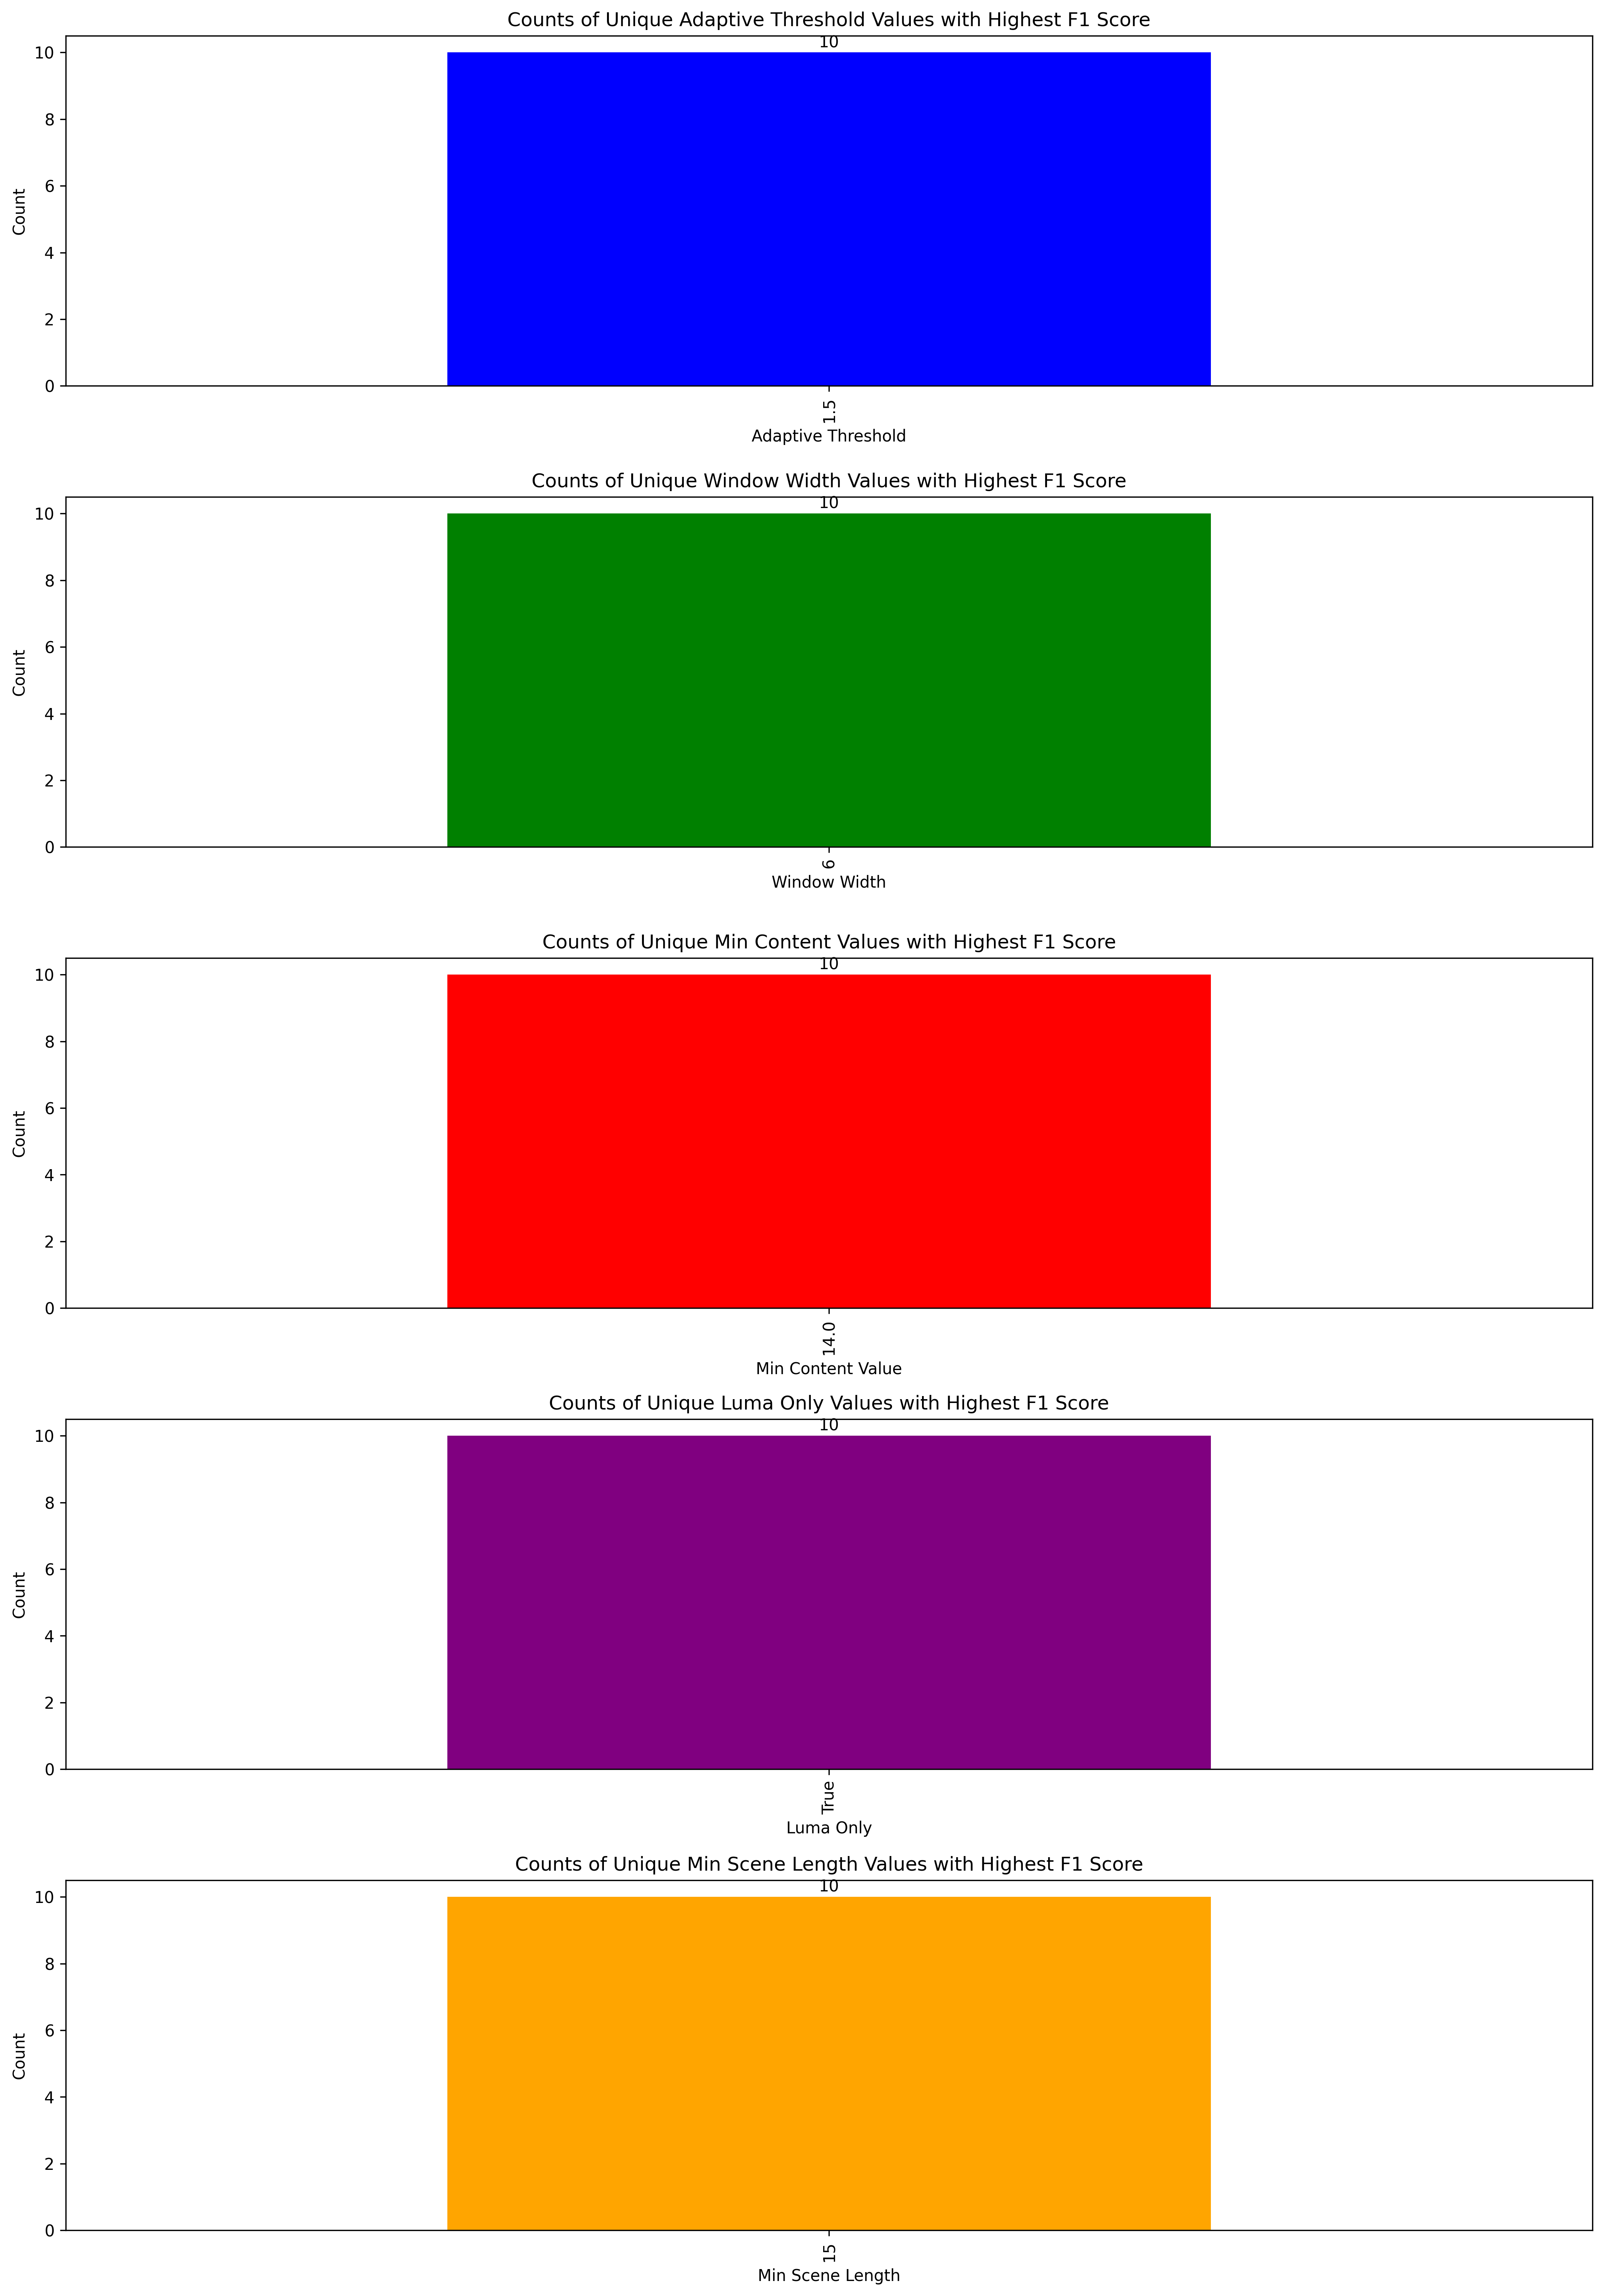

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Step 1: Initialize an empty DataFrame to store the optimal rows
optimal_values = pd.DataFrame()

# Step 2: Find rows with the highest F1 score for each video
for video in df['video'].unique():
    # Filter rows for the current video
    video_df = df[df['video'] == video]
    
    # Find the maximum F1 score for the current video
    max_f1 = video_df['f1'].max()
    
    # Select all rows that match the maximum F1 score for this video
    best_rows = video_df[video_df['f1'] == max_f1]
    
    # Append these rows to the optimal_values DataFrame
    optimal_values = pd.concat([optimal_values, best_rows])

# Reset index for the concatenated DataFrame
optimal_values.reset_index(drop=True, inplace=True)

# Step 3: Count occurrences of each unique value in the optimal rows for each parameter
adaptive_threshold_counts = optimal_values['adaptive_threshold'].value_counts().sort_index()
window_width_counts = optimal_values['window_width'].value_counts().sort_index()
min_content_val_counts = optimal_values['min_content_val'].value_counts().sort_index()
luma_only_counts = optimal_values['luma_only'].value_counts().sort_index()
min_scene_len_counts = optimal_values['min_scene_len'].value_counts().sort_index()

# Display the count tables
print("Counts for Adaptive Threshold:\n", adaptive_threshold_counts)
print("\nCounts for Window Width:\n", window_width_counts)
print("\nCounts for Min Content Value:\n", min_content_val_counts)
print("\nCounts for Luma Only:\n", luma_only_counts)
print("\nCounts for Min Scene Length:\n", min_scene_len_counts)

# Step 4: Plot each parameter's unique value counts and save as a single high-resolution image
plt.figure(figsize=(14, 20), dpi=300)  # Increase dpi for high resolution

# Adaptive Threshold Plot
plt.subplot(5, 1, 1)
bars = adaptive_threshold_counts.plot(kind='bar', color='b')
plt.title('Counts of Unique Adaptive Threshold Values with Highest F1 Score')
plt.xlabel('Adaptive Threshold')
plt.ylabel('Count')
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, 
             int(bar.get_height()), ha='center', va='bottom')

# Window Width Plot
plt.subplot(5, 1, 2)
bars = window_width_counts.plot(kind='bar', color='g')
plt.title('Counts of Unique Window Width Values with Highest F1 Score')
plt.xlabel('Window Width')
plt.ylabel('Count')
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, 
             int(bar.get_height()), ha='center', va='bottom')

# Min Content Value Plot
plt.subplot(5, 1, 3)
bars = min_content_val_counts.plot(kind='bar', color='r')
plt.title('Counts of Unique Min Content Values with Highest F1 Score')
plt.xlabel('Min Content Value')
plt.ylabel('Count')
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, 
             int(bar.get_height()), ha='center', va='bottom')

# Luma Only Plot
plt.subplot(5, 1, 4)
bars = luma_only_counts.plot(kind='bar', color='purple')
plt.title('Counts of Unique Luma Only Values with Highest F1 Score')
plt.xlabel('Luma Only')
plt.ylabel('Count')
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, 
             int(bar.get_height()), ha='center', va='bottom')

# Min Scene Length Plot
plt.subplot(5, 1, 5)
bars = min_scene_len_counts.plot(kind='bar', color='orange')
plt.title('Counts of Unique Min Scene Length Values with Highest F1 Score')
plt.xlabel('Min Scene Length')
plt.ylabel('Count')
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, 
             int(bar.get_height()), ha='center', va='bottom')

# Adjust layout
plt.tight_layout()

# Save the figure as a single high-resolution image to the specified directory
output_path = r"C:\Users\Yasin\00 Thesis\02 TransnetPySceneDetect\highest_f1_counts.png"
plt.savefig(output_path, dpi=300)  # Save with high resolution
plt.show()


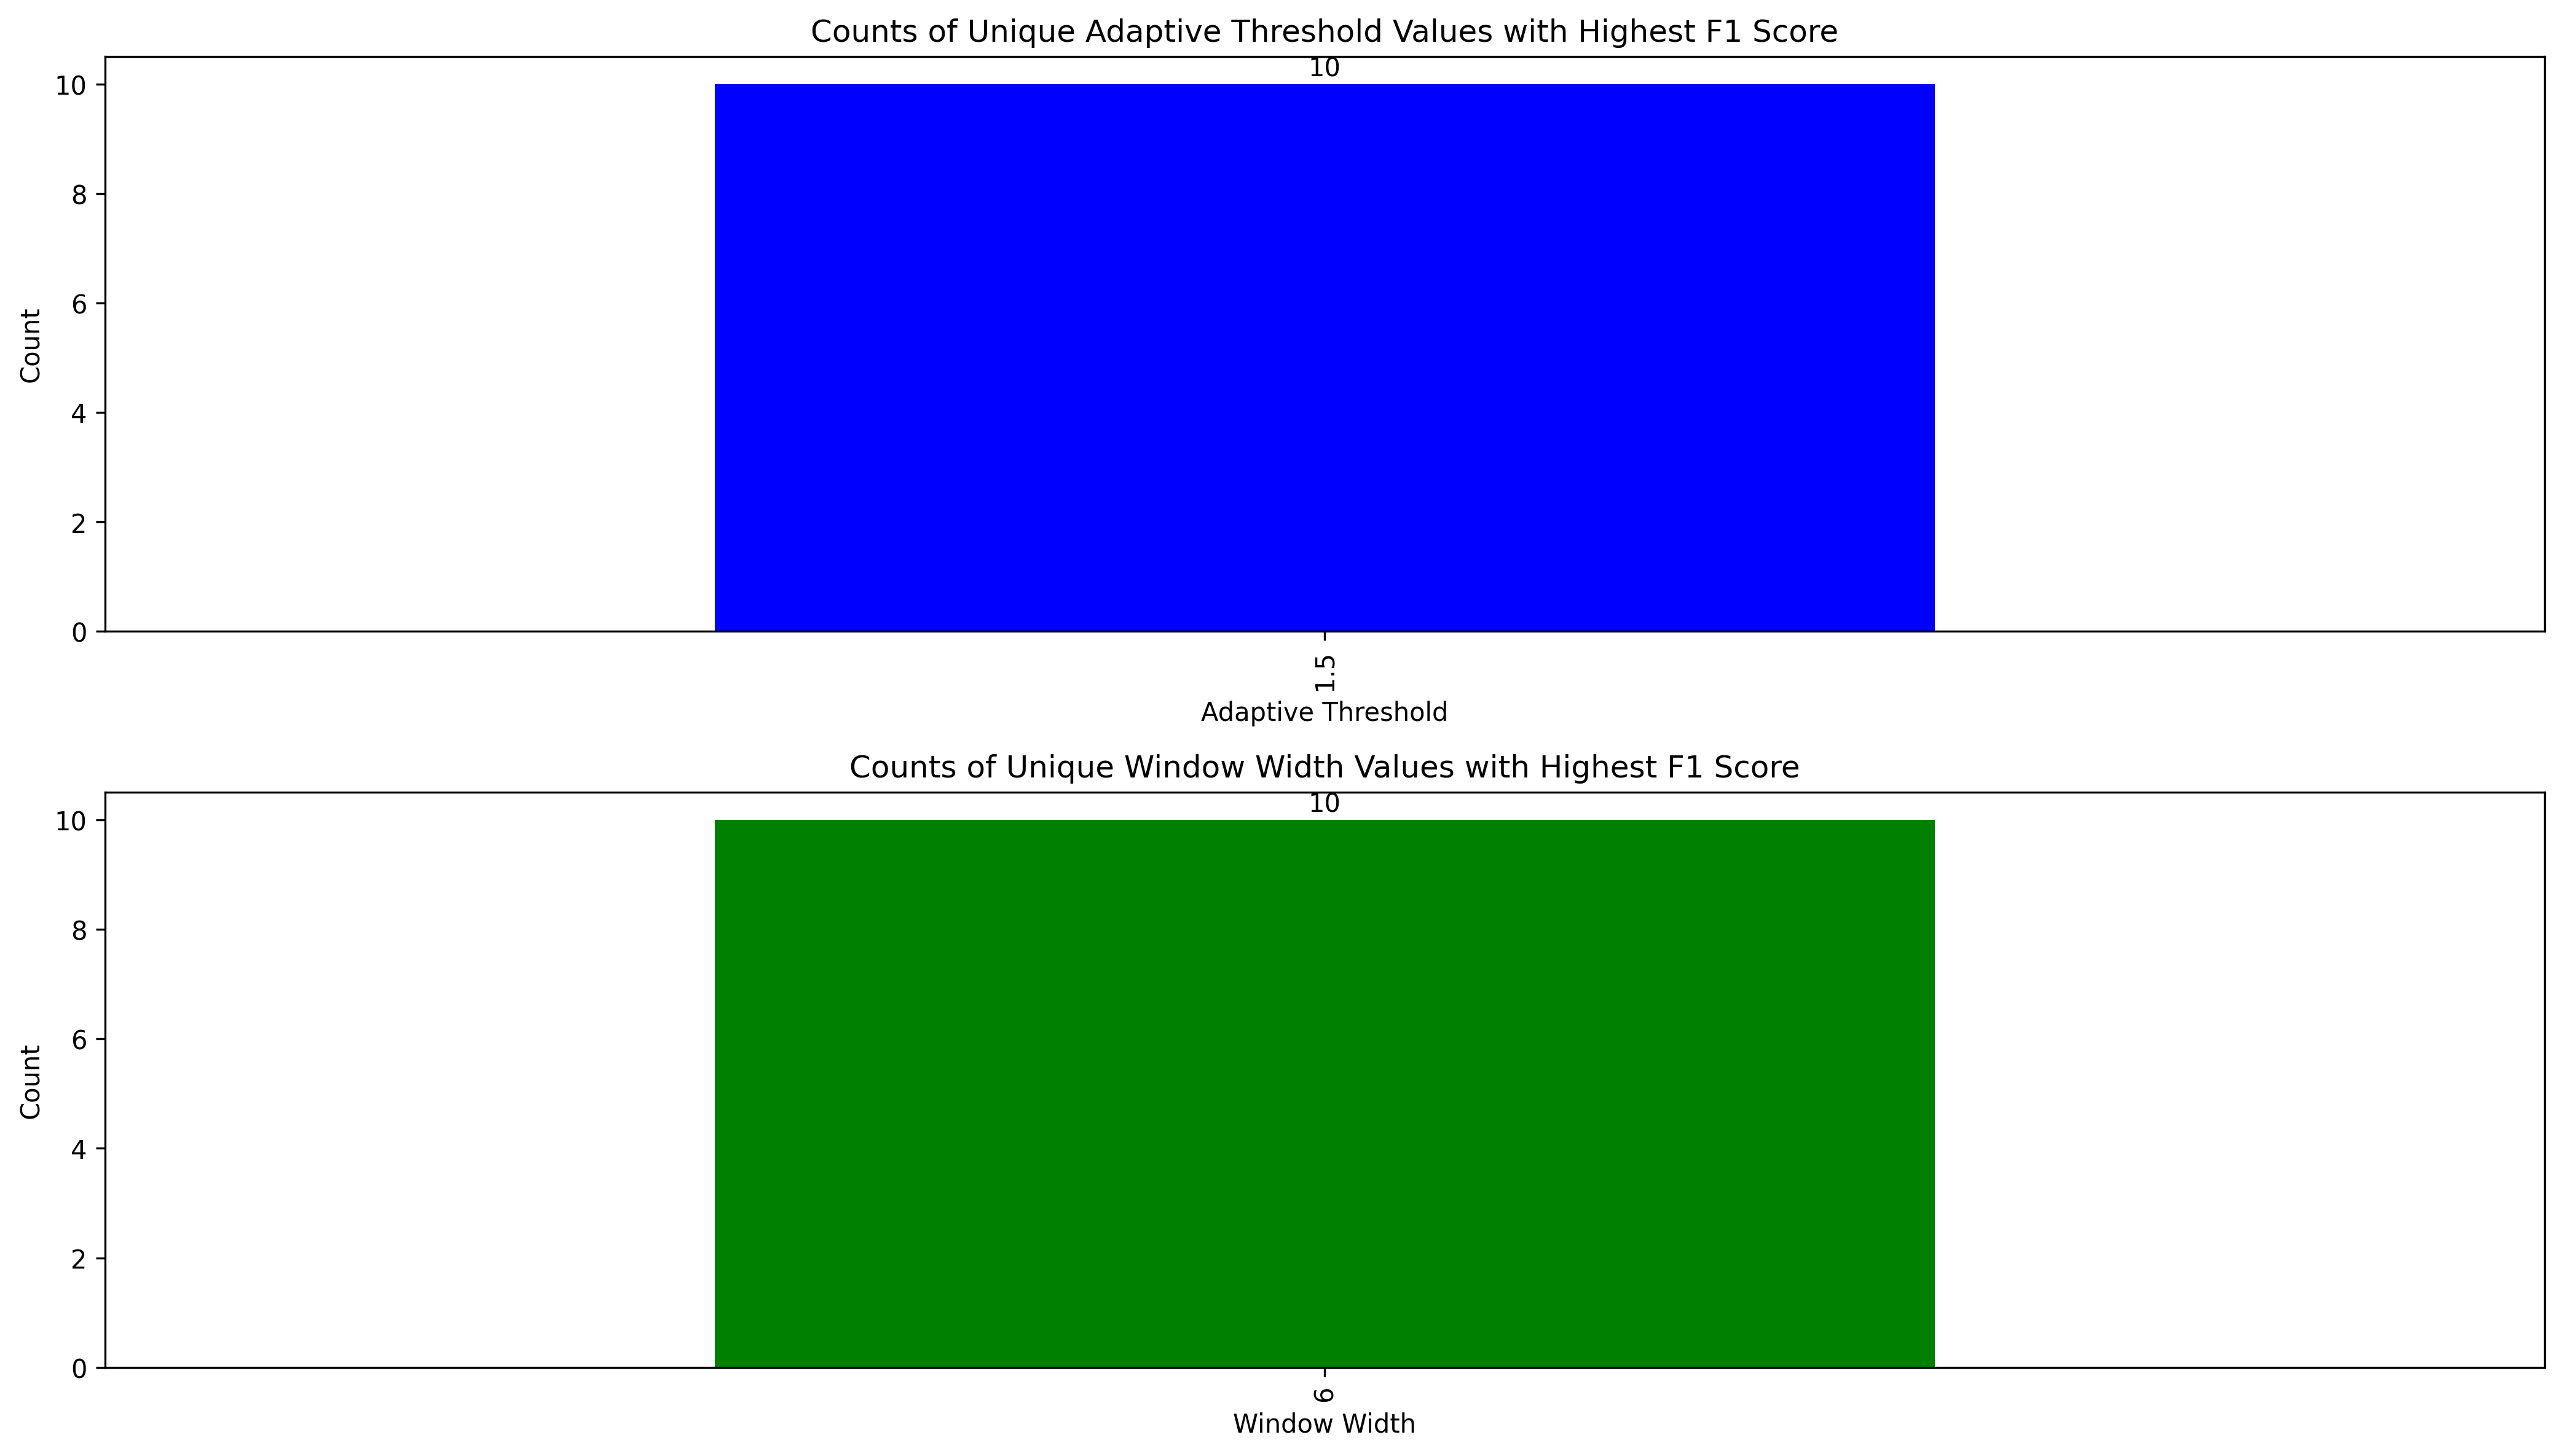

In [17]:
import matplotlib.pyplot as plt

# Set up the figure size and DPI
plt.figure(figsize=(14, 8), dpi=300)  # Adjusted height for two plots only

# Adaptive Threshold Plot
plt.subplot(2, 1, 1)
bars = adaptive_threshold_counts.plot(kind='bar', color='b')
plt.title('Counts of Unique Adaptive Threshold Values with Highest F1 Score')
plt.xlabel('Adaptive Threshold')
plt.ylabel('Count')
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
             int(bar.get_height()), ha='center', va='bottom')

# Window Width Plot
plt.subplot(2, 1, 2)
bars = window_width_counts.plot(kind='bar', color='g')
plt.title('Counts of Unique Window Width Values with Highest F1 Score')
plt.xlabel('Window Width')
plt.ylabel('Count')
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
             int(bar.get_height()), ha='center', va='bottom')

# Adjust layout and save as a high-resolution image
plt.tight_layout()
output_path = r"C:\Users\Yasin\00 Thesis\02 TransnetPySceneDetect\highest_f1_counts.png"
plt.savefig(output_path, dpi=300)  # Save with high resolution
plt.show()


In [18]:
import pandas as pd
from tabulate import tabulate  # Make sure to install with 'pip install tabulate' if not already installed

# Assuming df is your DataFrame
# Initialize a dictionary to store the results for each video
video_parameter_counts = {}

# Step 1: Loop through each unique video
for video in df['video'].unique():
    # Filter rows for the current video
    video_df = df[df['video'] == video]
    
    # Find the maximum F1 score for the current video
    max_f1 = video_df['f1'].max()
    
    # Select rows that match the maximum F1 score for this video
    best_rows = video_df[video_df['f1'] == max_f1]
    
    # Step 2: Count occurrences of each unique value in each parameter for these rows
    counts = {
        'adaptive_threshold': best_rows['adaptive_threshold'].value_counts(),
        'window_width': best_rows['window_width'].value_counts(),
        'min_content_val': best_rows['min_content_val'].value_counts(),
        'luma_only': best_rows['luma_only'].value_counts(),
        'min_scene_len': best_rows['min_scene_len'].value_counts()
    }
    
    # Store the counts for this video
    video_parameter_counts[video] = counts

# Step 3: Display results in table format for each video
for video, counts in video_parameter_counts.items():
    print(f"\n--- Counts for Video: {video} ---")
    
    # Combine counts into a single table
    table_data = []
    for param, count_series in counts.items():
        for value, count in count_series.items():
            table_data.append([param, value, count])
    
    # Use tabulate to print the table
    print(tabulate(table_data, headers=["Parameter", "Value", "Count"], tablefmt="fancy_grid"))



--- Counts for Video: A ---
╒════════════════════╤═════════╤═════════╕
│ Parameter          │   Value │   Count │
╞════════════════════╪═════════╪═════════╡
│ adaptive_threshold │     1.5 │       1 │
├────────────────────┼─────────┼─────────┤
│ window_width       │     6   │       1 │
├────────────────────┼─────────┼─────────┤
│ min_content_val    │    14   │       1 │
├────────────────────┼─────────┼─────────┤
│ luma_only          │     1   │       1 │
├────────────────────┼─────────┼─────────┤
│ min_scene_len      │    15   │       1 │
╘════════════════════╧═════════╧═════════╛

--- Counts for Video: B ---
╒════════════════════╤═════════╤═════════╕
│ Parameter          │   Value │   Count │
╞════════════════════╪═════════╪═════════╡
│ adaptive_threshold │     1.5 │       1 │
├────────────────────┼─────────┼─────────┤
│ window_width       │     6   │       1 │
├────────────────────┼─────────┼─────────┤
│ min_content_val    │    14   │       1 │
├────────────────────┼─────────┼───────

###### Scatter plot

In [19]:
# Rename columns in the DataFrame
df = df.rename(columns={
    'video':'Video',
    'Adaptive Threshold': 'adaptive_threshold',
    'Window Width': 'window_width',
    'Min Content Val': 'min_content_val',
    'Luma Only': 'luma_only',
    'Min Scene Len': 'min_scene_len',
    'F1 Score': 'f1',
    'Precision': 'precision',
    'Recall': 'recall'
})
#df['Video'] = df['Video'].str.replace('.mp4', '', regex=False)

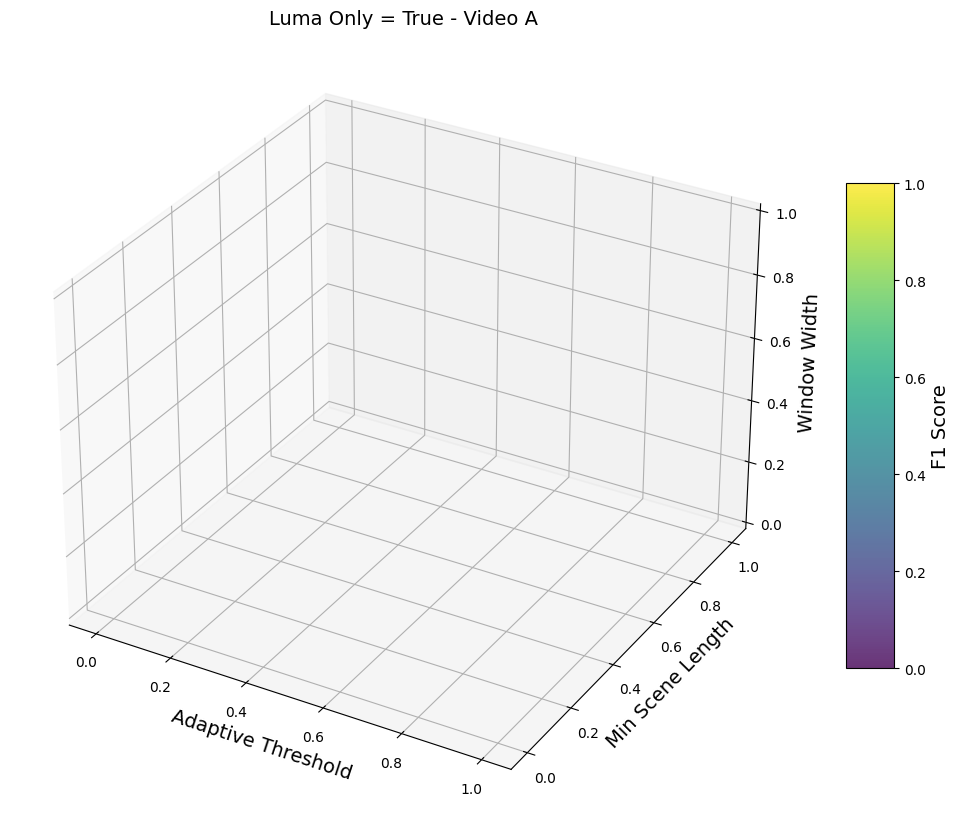

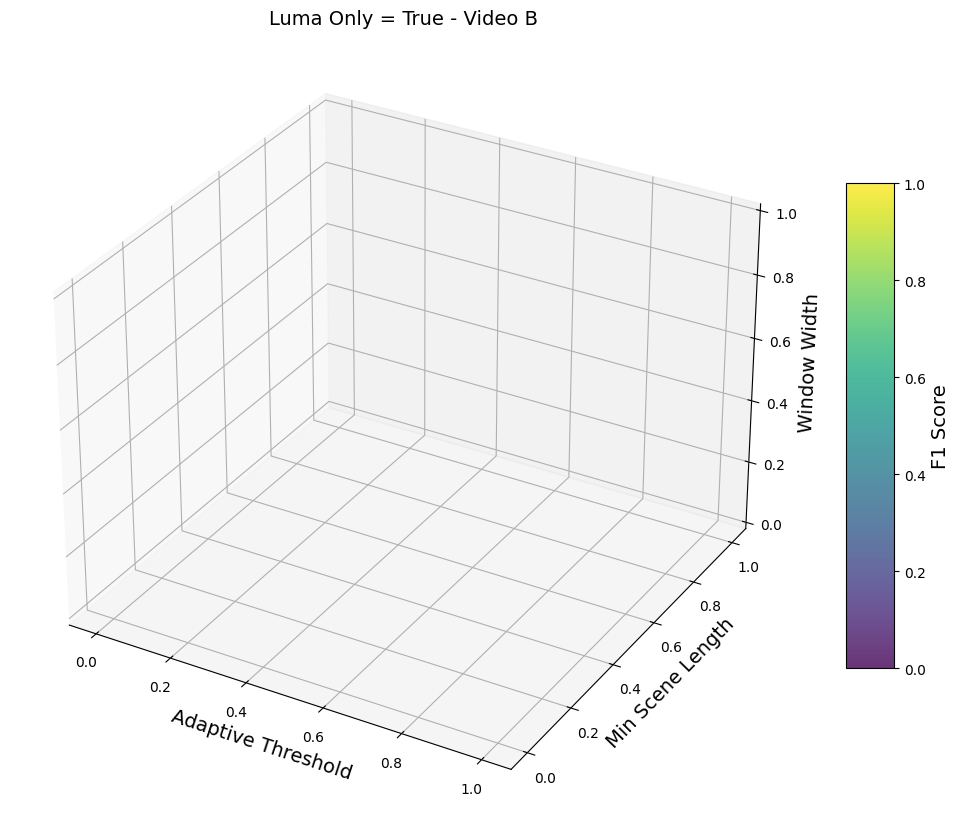

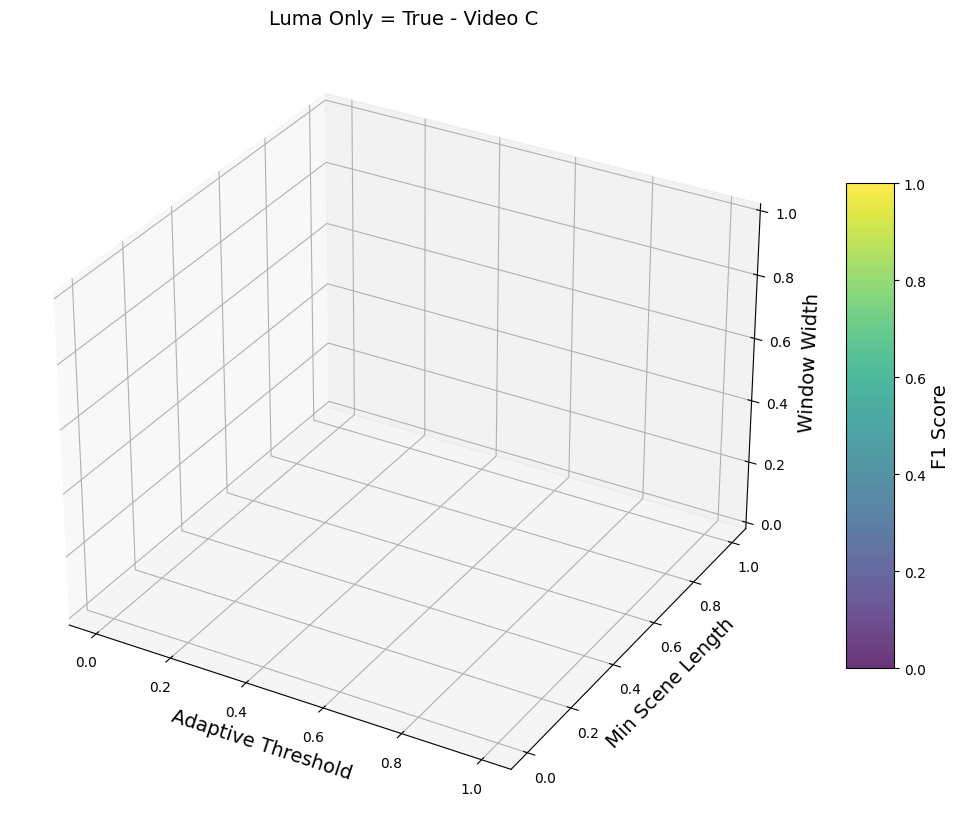

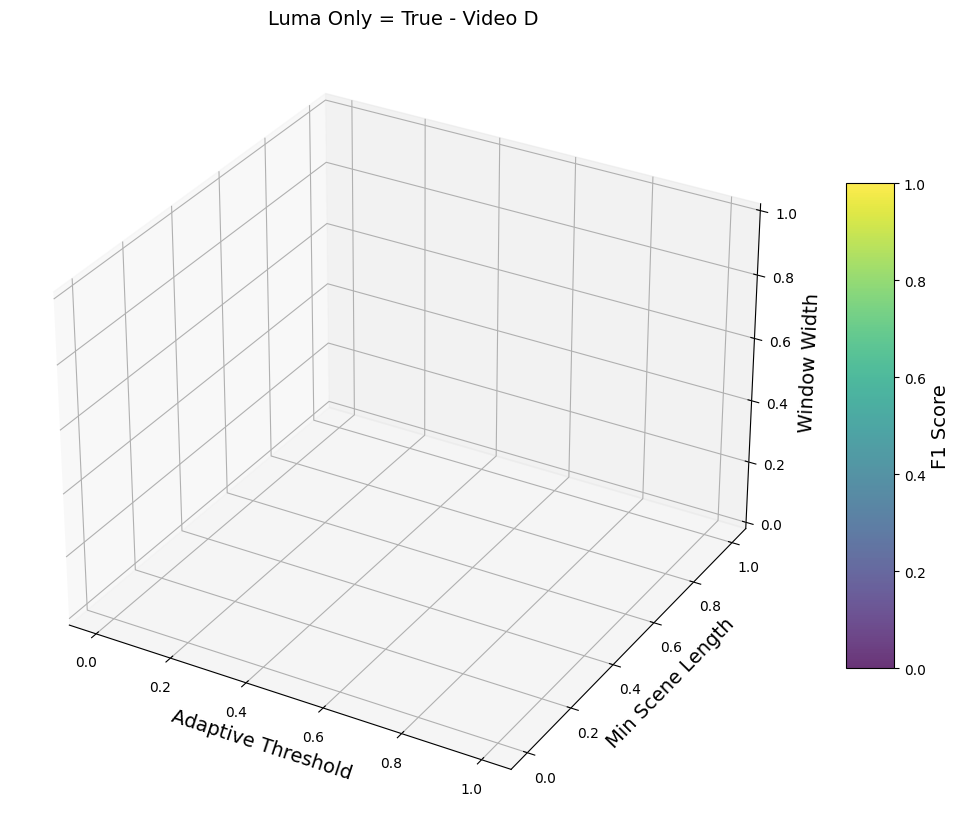

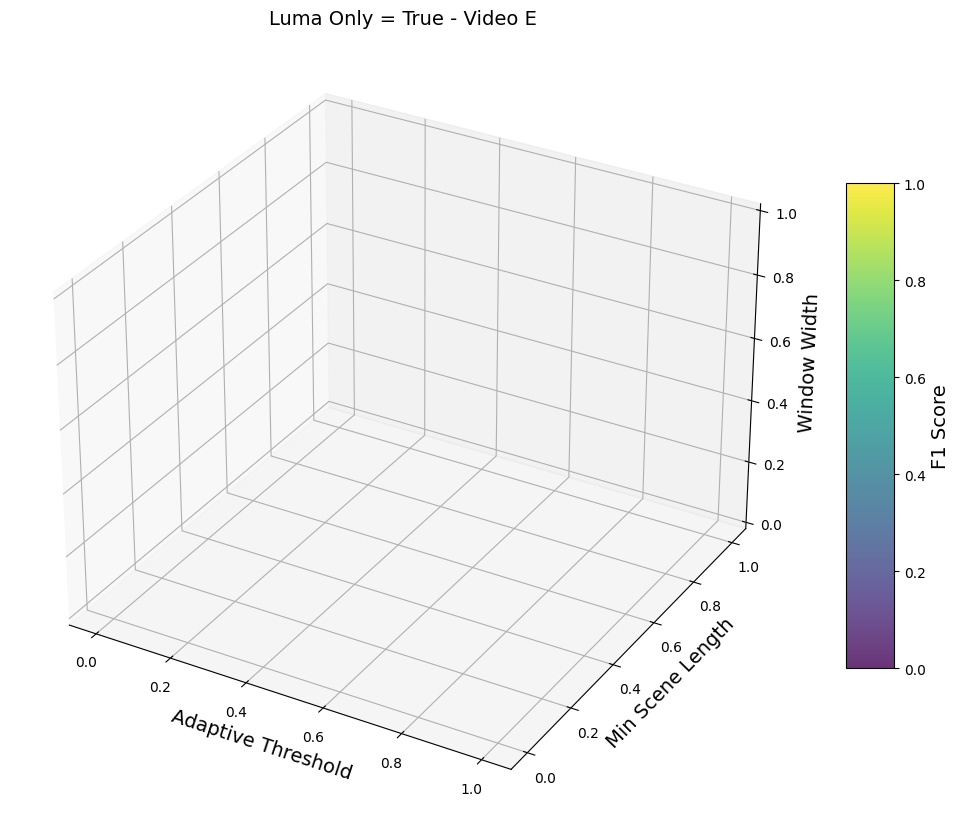

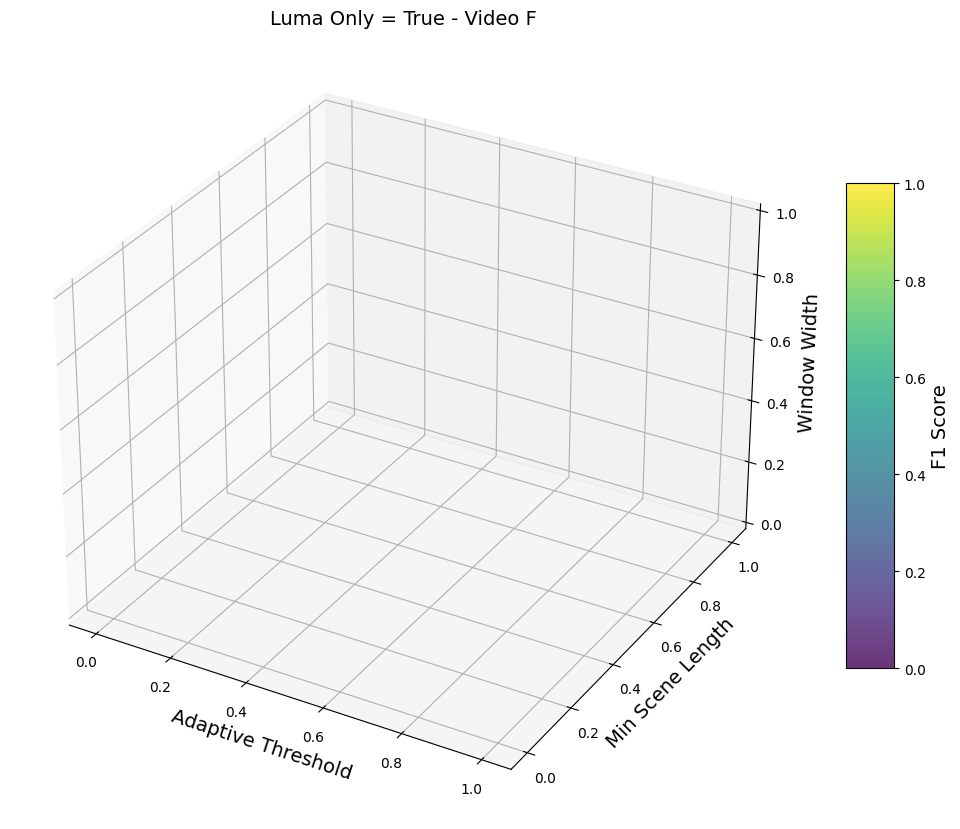

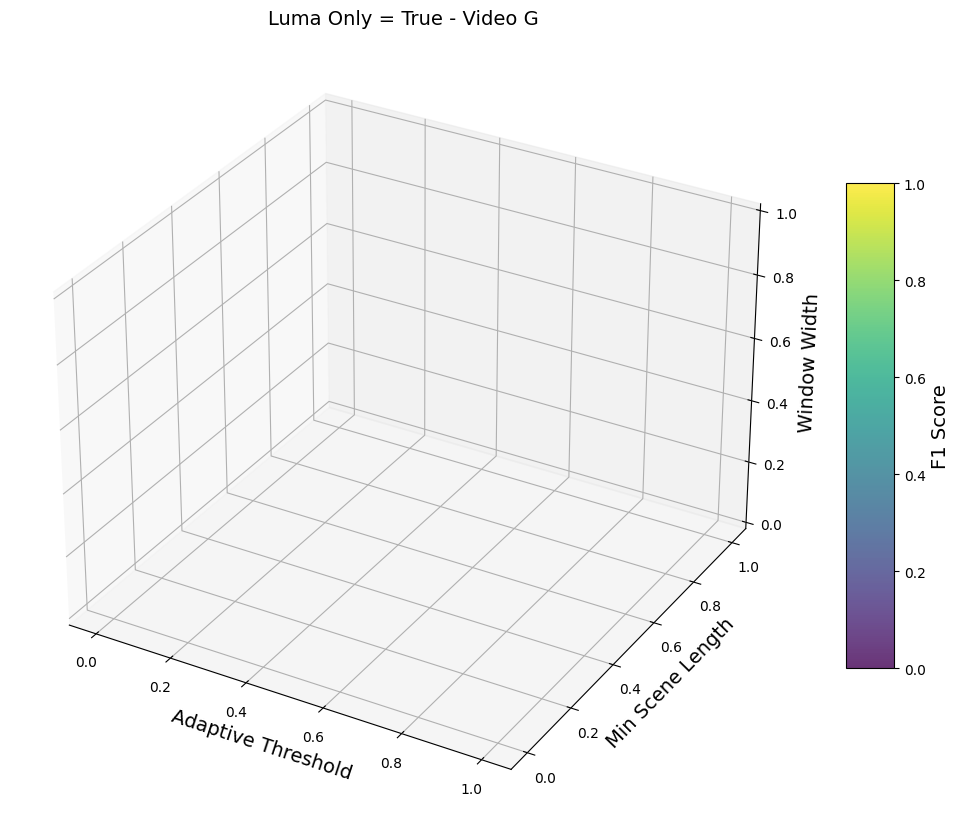

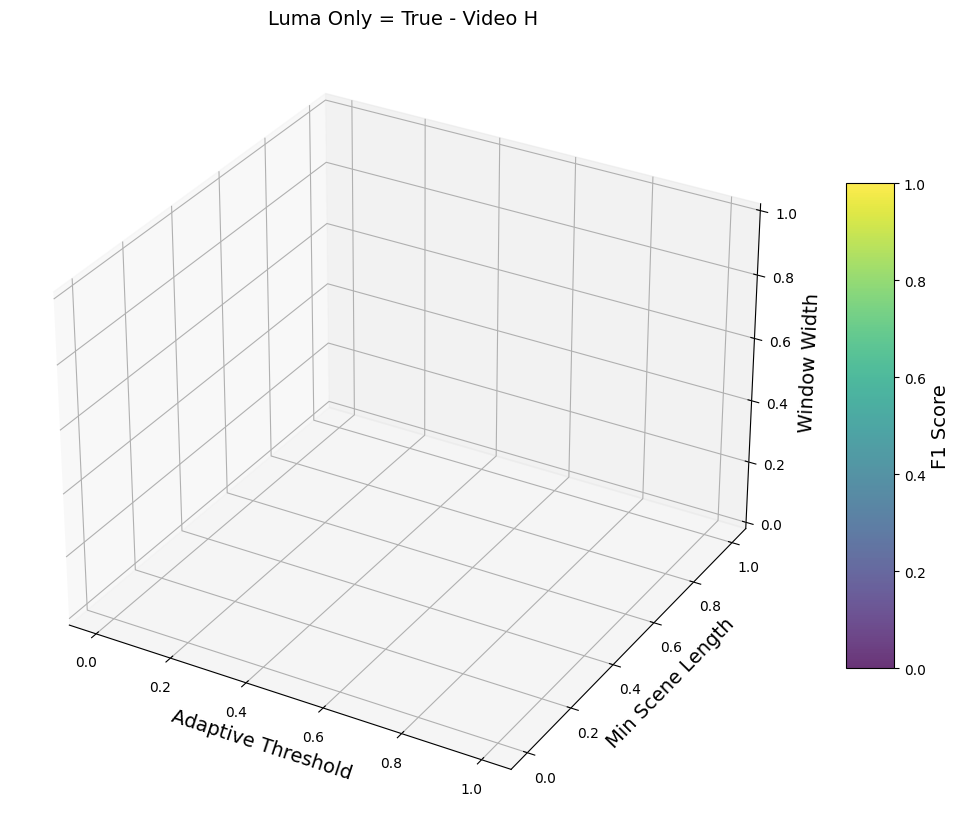

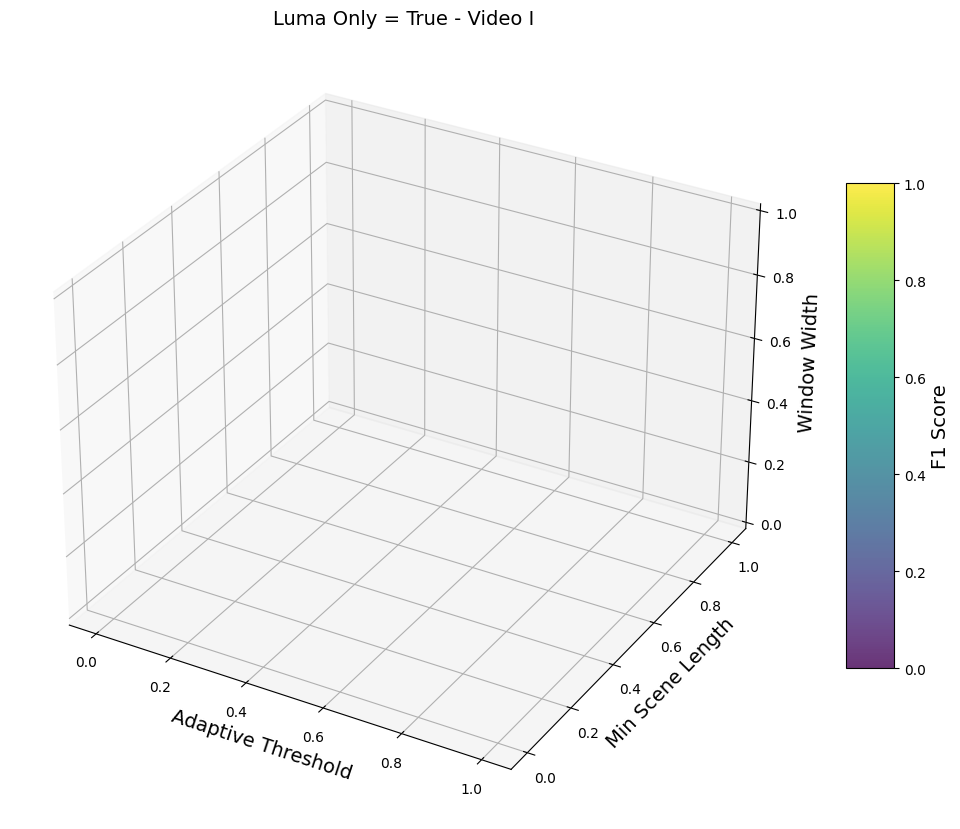

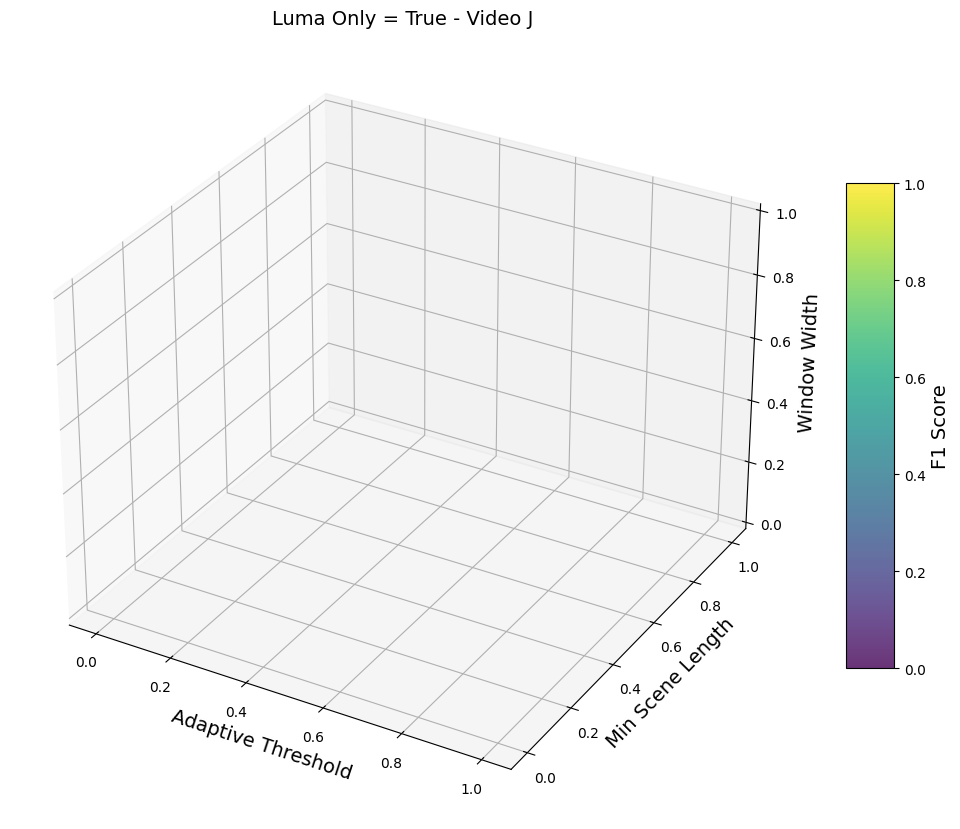

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import numpy as np

# Get unique video names from the existing df
video_values = df['Video'].unique()
# Loop through each unique value of 'Video'
for video in video_values:
    # Filter the DataFrame for the current video
    df_video = df[df['Video'] == video]
    
    # Separate DataFrames for luma_only = True and False
    df_luma_only_true = df_video[df_video["luma_only"] == True].reset_index(drop=True)
    df_luma_only_false = df_video[df_video["luma_only"] == False].reset_index(drop=True)
    
    # Initialize a single figure
    fig = plt.figure(figsize=(20, 10))
    
    # Define a function to normalize sizes for min_content_val
    def scale_sizes(values, min_size=20, max_size=200):
        normalized = (values - values.min()) / (values.max() - values.min())
        return normalized * (max_size - min_size) + min_size

    if not df_luma_only_true.empty:
        ax1 = fig.add_subplot(121, projection='3d')
        
        # Normalize the sizes for min_content_val
        sizes = scale_sizes(df_luma_only_true['min_content_val'])
        
        scatter1 = ax1.scatter(df_luma_only_true['adaptive_threshold'],
                               df_luma_only_true['min_scene_len'],
                               df_luma_only_true['window_width'],
                               c=df_luma_only_true['f1'],  # Color by F1 score
                               s=sizes,  # Size by normalized min_content_val
                               cmap='viridis',
                               alpha=0.8)
        
        ax1.set_xlabel('Adaptive Threshold', fontsize=14)  # Increase font size
        ax1.set_ylabel('Min Scene Length', fontsize=14)   # Increase font size
        ax1.set_zlabel('Window Width', fontsize=14)       # Increase font size
        cbar1 = fig.colorbar(scatter1, ax=ax1, shrink=0.5, aspect=10)
        cbar1.set_label('F1 Score', fontsize=14)  # Increase font size for colorbar label
        ax1.set_title(f'Luma Only = True - Video {video}', fontsize=14)  # Optional: Increase title font size
    
    if not df_luma_only_false.empty:
        ax2 = fig.add_subplot(122, projection='3d')
        
        # Normalize the sizes for min_content_val
        sizes = scale_sizes(df_luma_only_false['min_content_val'])
        
        scatter2 = ax2.scatter(df_luma_only_false['adaptive_threshold'],
                               df_luma_only_false['min_scene_len'],
                               df_luma_only_false['window_width'],
                               c=df_luma_only_false['f1'],  # Color by F1 score
                               s=sizes,  # Size by normalized min_content_val
                               cmap='viridis',
                               alpha=0.8)
        
        ax2.set_xlabel('Adaptive Threshold', fontsize=16)  # Increase font size
        ax2.set_ylabel('Min Scene Length', fontsize=16)   # Increase font size
        ax2.set_zlabel('Window Width', fontsize=16)       # Increase font size
        cbar2 = fig.colorbar(scatter2, ax=ax2, shrink=0.5, aspect=10)
        cbar2.set_label('F1 Score', fontsize=16)  # Increase font size for colorbar label
        ax2.set_title(f'Luma Only = False - Video {video}', fontsize=16)  # Optional: Increase title font size
    
    # Remove the overall figure title
    plt.tight_layout()
    plt.savefig(f'3D_Plots_F1_Video_{video}_Scaled.png', dpi=300)
    plt.show()


In [21]:
#pip install -U kaleido

######  pair plot

In [22]:
"""

# Get unique video names from the existing df
video_values = df['Video'].unique()

# Loop through each unique value of 'Video'
for video in video_values:
    # Filter the DataFrame for the current video
    df_video = df[df['Video'] == video]
    
    # Create DataFrame for 'Luma Only' == True
    df_luma_only_true = df_video[df_video["luma_only"] == True].reset_index(drop=True)
    
    # Create DataFrame for 'Luma Only' == False
    df_luma_only_false = df_video[df_video["luma_only"] == False].reset_index(drop=True)
    
    # Pairplot for luma_only = True if it is not empty
    if not df_luma_only_true.empty:
        sns.pairplot(data=df_luma_only_true,
                     vars=['adaptive_threshold', 'min_scene_len', 'window_width', 'min_content_val'],
                     hue='f1',
                     palette='viridis')
        plt.suptitle(f'Pairplot for luma_only = True - Video {video}', y=1.02)
        plt.show()
    
    # Pairplot for luma_only = False if it is not empty
    if not df_luma_only_false.empty:
        sns.pairplot(data=df_luma_only_false,
                     vars=['adaptive_threshold', 'min_scene_len', 'window_width', 'min_content_val'],
                     hue='f1',
                     palette='viridis')
        plt.suptitle(f'Pairplot for luma_only = False - Video {video}', y=1.02)
        plt.show()
"""

'\n\n# Get unique video names from the existing df\nvideo_values = df[\'Video\'].unique()\n\n# Loop through each unique value of \'Video\'\nfor video in video_values:\n    # Filter the DataFrame for the current video\n    df_video = df[df[\'Video\'] == video]\n    \n    # Create DataFrame for \'Luma Only\' == True\n    df_luma_only_true = df_video[df_video["luma_only"] == True].reset_index(drop=True)\n    \n    # Create DataFrame for \'Luma Only\' == False\n    df_luma_only_false = df_video[df_video["luma_only"] == False].reset_index(drop=True)\n    \n    # Pairplot for luma_only = True if it is not empty\n    if not df_luma_only_true.empty:\n        sns.pairplot(data=df_luma_only_true,\n                     vars=[\'adaptive_threshold\', \'min_scene_len\', \'window_width\', \'min_content_val\'],\n                     hue=\'f1\',\n                     palette=\'viridis\')\n        plt.suptitle(f\'Pairplot for luma_only = True - Video {video}\', y=1.02)\n        plt.show()\n    \n    # P

###### Scatter plot - merging the data based on the value of min_content_val and MinMax of f1

In [23]:

"""



# Get unique video names
video_values = df['Video'].unique()

# Define min_content_vals for plotting
min_content_vals = [10.0, 12.0, 15.0, 20.0, 25.0]

# Loop through each unique value of 'Video'
for video in video_values:
    # Filter the DataFrame for the current video
    df_video = df[df['Video'] == video]
    
    # Create DataFrame for 'Luma Only' == True
    df_luma_only_true = df_video[df_video["luma_only"] == True].reset_index(drop=True)
    
    # Create DataFrame for 'Luma Only' == False
    df_luma_only_false = df_video[df_video["luma_only"] == False].reset_index(drop=True)

    # Generate 3D histograms for luma_only = True
    for val in min_content_vals:
        data_val = df_luma_only_true[df_luma_only_true['min_content_val'] == val]

        if not data_val.empty:
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')

            x = data_val['adaptive_threshold']
            y = data_val['min_scene_len']
            z = data_val['window_width']
            f1 = data_val['f1']

            # Define the edges of the bins
            xedges = np.linspace(x.min(), x.max(), 10)
            yedges = np.linspace(y.min(), y.max(), 10)
            zedges = np.linspace(z.min(), z.max(), 10)

            # Compute the histogram
            hist, edges = np.histogramdd((x, y, z), bins=(xedges, yedges, zedges))

            # Calculate the density of F1 scores in each bin
            data_points = np.vstack([x, y, z])
            kde = gaussian_kde(data_points, weights=f1)
            density = kde(data_points)

            # Find the bins with high density of high F1 scores
            threshold = np.percentile(density, 80)

            # Plot the histogram bins
            for i in range(len(xedges) - 1):
                for j in range(len(yedges) - 1):
                    for k in range(len(zedges) - 1):
                        x0, x1 = xedges[i], xedges[i + 1]
                        y0, y1 = yedges[j], yedges[j + 1]
                        z0, z1 = zedges[k], zedges[k + 1]
                        bin_density = kde([x0 + (x1 - x0) / 2, y0 + (y1 - y0) / 2, z0 + (z1 - z0) / 2])
                        if bin_density > threshold:
                            ax.bar3d(x0, y0, z0, x1 - x0, y1 - y0, z1 - z0, color='red', alpha=0.5)
                        else:
                            ax.bar3d(x0, y0, z0, x1 - x0, y1 - y0, z1 - z0, color='blue', alpha=0.1)

            ax.set_xlabel('Adaptive Threshold')
            ax.set_ylabel('Min Scene Length')
            ax.set_zlabel('Window Width')

            plt.title(f'3D Histogram for luma_only = True - Video {video}, min_content_val = {val}')
            plt.show()

    # Generate 3D histograms for luma_only = False
    for val in min_content_vals:
        data_val = df_luma_only_false[df_luma_only_false['min_content_val'] == val]

        if not data_val.empty:
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')

            x = data_val['adaptive_threshold']
            y = data_val['min_scene_len']
            z = data_val['window_width']
            f1 = data_val['f1']

            # Define the edges of the bins
            xedges = np.linspace(x.min(), x.max(), 10)
            yedges = np.linspace(y.min(), y.max(), 10)
            zedges = np.linspace(z.min(), z.max(), 10)

            # Compute the histogram
            hist, edges = np.histogramdd((x, y, z), bins=(xedges, yedges, zedges))

            # Calculate the density of F1 scores in each bin
            data_points = np.vstack([x, y, z])
            kde = gaussian_kde(data_points, weights=f1)
            density = kde(data_points)

            # Find the bins with high density of high F1 scores
            threshold = np.percentile(density, 80)

            # Plot the histogram bins
            for i in range(len(xedges) - 1):
                for j in range(len(yedges) - 1):
                    for k in range(len(zedges) - 1):
                        x0, x1 = xedges[i], xedges[i + 1]
                        y0, y1 = yedges[j], yedges[j + 1]
                        z0, z1 = zedges[k], zedges[k + 1]
                        bin_density = kde([x0 + (x1 - x0) / 2, y0 + (y1 - y0) / 2, z0 + (z1 - z0) / 2])
                        if bin_density > threshold:
                            ax.bar3d(x0, y0, z0, x1 - x0, y1 - y0, z1 - z0, color='red', alpha=0.5)
                        else:
                            ax.bar3d(x0, y0, z0, x1 - x0, y1 - y0, z1 - z0, color='blue', alpha=0.1)

            ax.set_xlabel('Adaptive Threshold')
            ax.set_ylabel('Min Scene Length')
            ax.set_zlabel('Window Width')

            plt.title(f'3D Histogram for luma_only = False - Video {video}, min_content_val = {val}')
            plt.show()


"""

'\n\n\n\n# Get unique video names\nvideo_values = df[\'Video\'].unique()\n\n# Define min_content_vals for plotting\nmin_content_vals = [10.0, 12.0, 15.0, 20.0, 25.0]\n\n# Loop through each unique value of \'Video\'\nfor video in video_values:\n    # Filter the DataFrame for the current video\n    df_video = df[df[\'Video\'] == video]\n    \n    # Create DataFrame for \'Luma Only\' == True\n    df_luma_only_true = df_video[df_video["luma_only"] == True].reset_index(drop=True)\n    \n    # Create DataFrame for \'Luma Only\' == False\n    df_luma_only_false = df_video[df_video["luma_only"] == False].reset_index(drop=True)\n\n    # Generate 3D histograms for luma_only = True\n    for val in min_content_vals:\n        data_val = df_luma_only_true[df_luma_only_true[\'min_content_val\'] == val]\n\n        if not data_val.empty:\n            fig = plt.figure(figsize=(10, 7))\n            ax = fig.add_subplot(111, projection=\'3d\')\n\n            x = data_val[\'adaptive_threshold\']\n         

###### Parallel cordinates of best combination

In [24]:
import pandas as pd
import plotly.express as px
from tabulate import tabulate

# Assuming df is already defined and contains your data
# Define the F1 score threshold
f1_threshold = 0.74

# Filter the data for F1 scores greater than the threshold
high_f1_data = df[df['f1'] > f1_threshold]

# Group by hyperparameters and count occurrences
grouped_data = high_f1_data.groupby(['luma_only', 'adaptive_threshold', 'min_scene_len', 'window_width', 'min_content_val'])
counts = grouped_data.size()

# Find valid combinations (those that have at least the number of original CSVs)
valid_combinations = counts[counts >= len(df['Video'].unique())]  # Use the number of unique video values

# Find the maximum count among valid combinations
max_count = valid_combinations.max()

# Find all combinations with the maximum count
best_combinations = valid_combinations[valid_combinations == max_count].index

# Check if there are best combinations
if best_combinations.empty:
    print("No best combinations found")
else:
    # Extract data for the best combinations
    best_combination_data = pd.DataFrame()
    for comb in best_combinations:
        best_combination_data = best_combination_data.append(high_f1_data[
            (high_f1_data['luma_only'] == comb[0]) &
            (high_f1_data['adaptive_threshold'] == comb[1]) &
            (high_f1_data['min_scene_len'] == comb[2]) &
            (high_f1_data['window_width'] == comb[3]) &
            (high_f1_data['min_content_val'] == comb[4])
        ])

    # Convert 'luma_only' to string for visualization
    best_combination_data['luma_only'] = best_combination_data['luma_only'].astype(str)

    # Create the parallel coordinates plot
    fig = px.parallel_coordinates(
        best_combination_data,
        dimensions=['luma_only', 'adaptive_threshold', 'min_scene_len', 'window_width', 'min_content_val', 'f1'],
        color='f1',
        color_continuous_scale=px.colors.diverging.Tealrose,
        labels={
            'luma_only': 'Luma Only',
            'adaptive_threshold': 'Adaptive Threshold',
            'min_scene_len': 'Min Scene Length',
            'window_width': 'Window Width',
            'min_content_val': 'Min Content Value',
            'f1': 'F1 Score',
        },
    )

    # Adjusting plot layout for better contrast
    fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        font_color='black',
        font_size=20,  # Increase font size for better readability
        width=900,
    )

    # Show the plot
    fig.show()


No best combinations found


#### parallal coordinate top 10 f1

In [25]:
import pandas as pd
import plotly.express as px

# Assuming df is already defined and contains your data

# Step 1: Find all rows with the highest F1 score for each video
highest_f1_per_video = df[df.groupby('Video')['f1'].transform(max) == df['f1']]

# Step 2: Convert 'luma_only' to string for visualization
highest_f1_per_video['luma_only'] = highest_f1_per_video['luma_only'].astype(str)

# Step 3: Create the parallel coordinates plot
fig = px.parallel_coordinates(
    highest_f1_per_video,
    dimensions=['luma_only', 'adaptive_threshold', 'min_scene_len', 'window_width', 'min_content_val', 'f1'],
    color='f1',
    color_continuous_scale=px.colors.diverging.Tealrose,
    labels={
        'luma_only': 'Luma Only',
        'adaptive_threshold': 'Adaptive Threshold',
        'min_scene_len': 'Min Scene Length',
        'window_width': 'Window Width',
        'min_content_val': 'Min Content Value',
        'f1': 'F1 Score',
    },
)

# Adjusting plot layout for better contrast
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font_color='black',
    font_size=20,  # Increase font size for better readability
    width=900,
)

# Step 4: Show the plot
fig.show()

   # Remove the overall figure title
plt.tight_layout()
plt.savefig(f'parallal.png', dpi=300)
plt.show()


<Figure size 640x480 with 0 Axes>

In [26]:
highest_f1_per_video.shape

(10, 18)

### parallal coordinate all highest f1

In [27]:
import pandas as pd
import plotly.express as px

# Assuming df is already defined and contains your data

# Step 1: Find all rows with the highest F1 score for each video
highest_f1_per_video = df[df.groupby('Video')['f1'].transform(max) == df['f1']]

# Step 2: Convert 'luma_only' to string for visualization
highest_f1_per_video['luma_only'] = highest_f1_per_video['luma_only'].astype(str)

# Step 3: Create the parallel coordinates plot
fig = px.parallel_coordinates(
    highest_f1_per_video,
    dimensions=['luma_only', 'adaptive_threshold', 'min_scene_len', 'window_width', 'min_content_val', 'f1'],
    color='f1',
    color_continuous_scale=px.colors.diverging.Tealrose,
    labels={
        'luma_only': 'Luma Only',
        'adaptive_threshold': 'Adaptive Threshold',
        'min_scene_len': 'Min Scene Length',
        'window_width': 'Window Width',
        'min_content_val': 'Min Content Value',
        'f1': 'F1 Score',
    },
)

# Adjusting plot layout for better contrast
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font_color='black',
    font_size=20,  # Increase font size for better readability
    width=900,
)

# Step 4: Show the plot
fig.show()


In [28]:
highest_f1_per_video.shape

(10, 18)

In [29]:
video_mapping

NameError: name 'video_mapping' is not defined

In [ ]:
import pandas as pd
import plotly.express as px

# Assuming df is already defined and contains your data

# Step 1: Find all rows with the highest F1 score for each video
highest_f1_per_video = df[df.groupby('Video')['f1'].transform(max) == df['f1']]

# Step 2: Convert 'luma_only' to 0/1 (False/True) for better visualization
highest_f1_per_video.loc[:, 'luma_only'] = highest_f1_per_video['luma_only'].astype(int)

# Step 3: Convert 'Video' to numeric labels (A=1, B=2, etc.) and ensure sorting
video_mapping = {video: idx + 1 for idx, video in enumerate(sorted(highest_f1_per_video['Video'].unique()))}
highest_f1_per_video['Video'] = highest_f1_per_video['Video'].map(video_mapping)

# Step 4: Sort by 'Video' to ensure ascending order in the plot
highest_f1_per_video = highest_f1_per_video.sort_values('Video')

# Step 5: Create the parallel coordinates plot
fig = px.parallel_coordinates(
    highest_f1_per_video,
    dimensions=['Video', 'luma_only', 'adaptive_threshold', 'min_scene_len', 'window_width', 'min_content_val', 'f1'],
    color='f1',
    color_continuous_scale=px.colors.diverging.Tealrose,
    labels={
        'Video': 'Video',
        'luma_only': 'Luma Only',
        'adaptive_threshold': 'Adaptive Threshold',
        'min_scene_len': 'Min Scene Length',
        'window_width': 'Window Width',
        'min_content_val': 'Min Content Value',
        'f1': 'F1',
    },
)

# Adjusting plot layout for better contrast
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font_color='black',
    font_size=14,  # Increase font size for better readability
    width=1200,    # Adjust width for better visualization
)

# Step 6: Show the plot
fig.show()


### parallel cordinate f1 threshold

In [ ]:
import pandas as pd
import plotly.express as px

# Assuming df is already defined and contains your data

# Step 1: Define a threshold for the 'f1' score
f1_threshold = 0.75  # Example threshold for the f1 score

# Step 2: Filter the DataFrame to only include rows where 'f1' is above the threshold
filtered_df = df[df['f1'] >= f1_threshold]

# Check if there are any rows remaining after filtering
#print(f"Filtered DataFrame (first 5 rows):\n{filtered_df.head()}")

# Step 3: Convert 'luma_only' to string for visualization (if necessary)
filtered_df['luma_only'] = filtered_df['luma_only'].astype(str)

# Step 4: Create the parallel coordinates plot with the filtered data
fig = px.parallel_coordinates(
    filtered_df,  # Use the filtered data
    dimensions=['luma_only', 'adaptive_threshold', 'min_scene_len', 'window_width', 'min_content_val', 'f1'],
    color='f1',
    color_continuous_scale=px.colors.diverging.Tealrose,
    labels={
        'luma_only': 'Luma Only',
        'adaptive_threshold': 'Adaptive Threshold',
        'min_scene_len': 'Min Scene Length',
        'window_width': 'Window Width',
        'min_content_val': 'Min Content Value',
        'f1': 'F1 Score',
    },
)

# Adjusting plot layout for better contrast
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font_color='black',
    font_size=20,  # Increase font size for better readability
    width=900,
)

# Step 5: Show the plot
fig.show()


In [ ]:
filtered_df.shape